# 🎨 Tutorial: Mastering Curve Generation for DSA-RL

Welcome! This notebook is designed to help you understand how our curve generator works. You'll learn how to manipulate geometry, add realistic noise, and configure different "stages" of difficulty for our AI agent.

## 🛠️ 1. Setup
If you are running this in **Google Colab**, we first need to clone the repository to access the generator modules.

In [102]:
# Run this ONLY if you are in Colab
# !git clone https://github.com/mahsaabadian/DSA-RL-Tracker.git
# %cd DSA-RL-Tracker

Now let's import our unified `CurveMaker` and some visualization tools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Ensure plots show up in Cursor/VS Code
%matplotlib inline

# Force path to project root
sys.path.append(os.getcwd())

from CurveGeneratorModule import CurveMaker
import cv2

def show_samples(maker, params, num_examples=3, show_mask=False, show_points=False, title=None):
    # Determine grid layout
    if show_mask:
        rows = num_examples
        cols = 2
    else:
        rows = 1
        cols = num_examples
    
    # Create figure. Extra height if title is present.
    fig_height = 4 * rows + (0.5 if title else 0)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, fig_height), squeeze=False)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    for i in range(num_examples):
        # Generate a fresh sample using the provided params
        if show_points:
            img, mask, _, cps = maker.sample_curve(return_control_points=True, **params)
        else:
            img, mask, _ = maker.sample_curve(**params)
        
        # Assign axes based on layout
        if show_mask:
            ax_img = axes[i, 0]
            ax_mask = axes[i, 1]
        else:
            ax_img = axes[0, i]
        
        # Display Image
        ax_img.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax_img.set_title(f"Example {i+1}")
        ax_img.axis('off')
        
        # Optionally overlay control points (in red)
        if show_points and cps:
            for seg_cps in cps:
                seg_cps = np.array(seg_cps)
                ax_img.scatter(seg_cps[:,1], seg_cps[:,0], c='red', s=10, marker='x')
        
        # Display Mask (optional)
        if show_mask:
            ax_mask.imshow(mask, cmap='gray', vmin=0, vmax=1)
            ax_mask.set_title(f"Mask {i+1}")
            ax_mask.axis('off')
            
    plt.tight_layout()
    plt.show()

## 🧪 5. Attribute Deep Dive

In this section, we test every single attribute available in the configuration. Use these cells to see exactly how each parameter affects the output.

---

### 5.1 `num_control_points` (Complexity)
Defines the degree of the Bezier curve. 
- 4: Simple cubic curve.
- 8: High complexity, lots of wiggles.

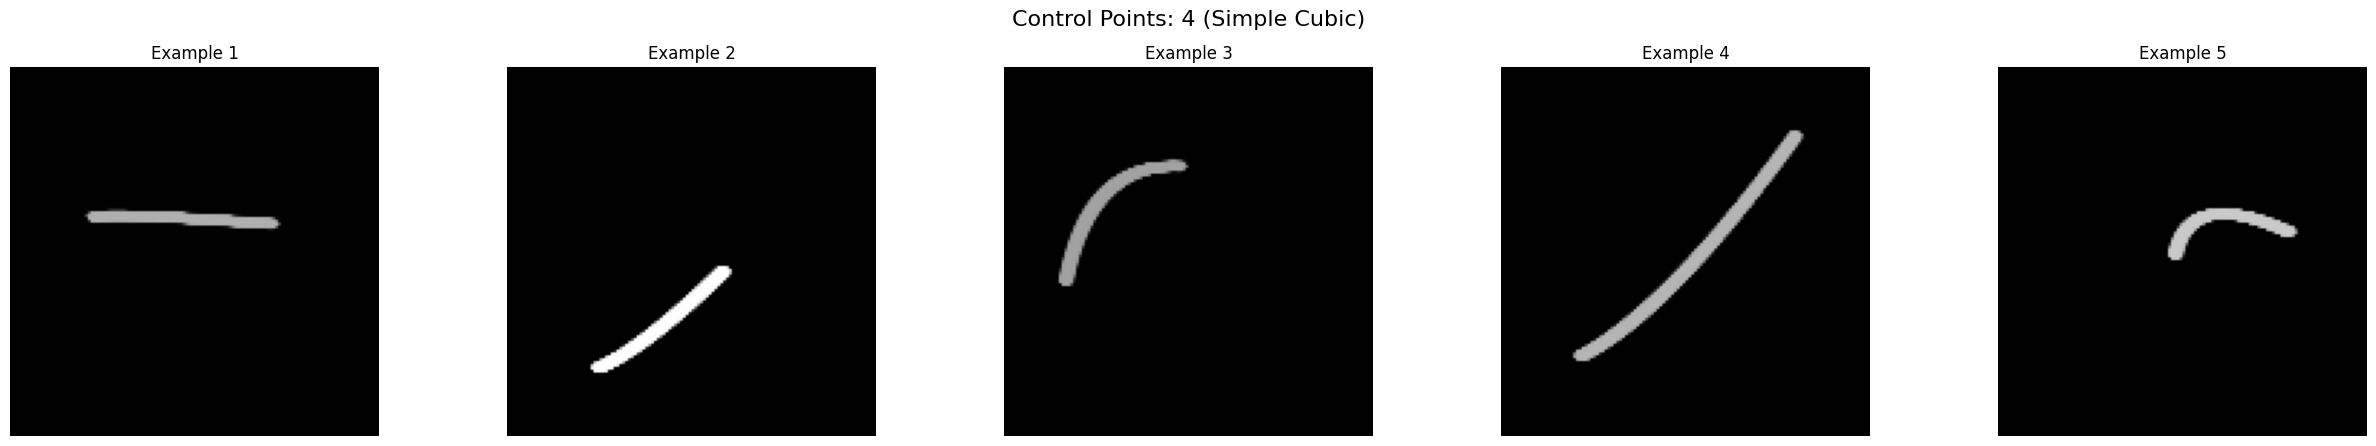

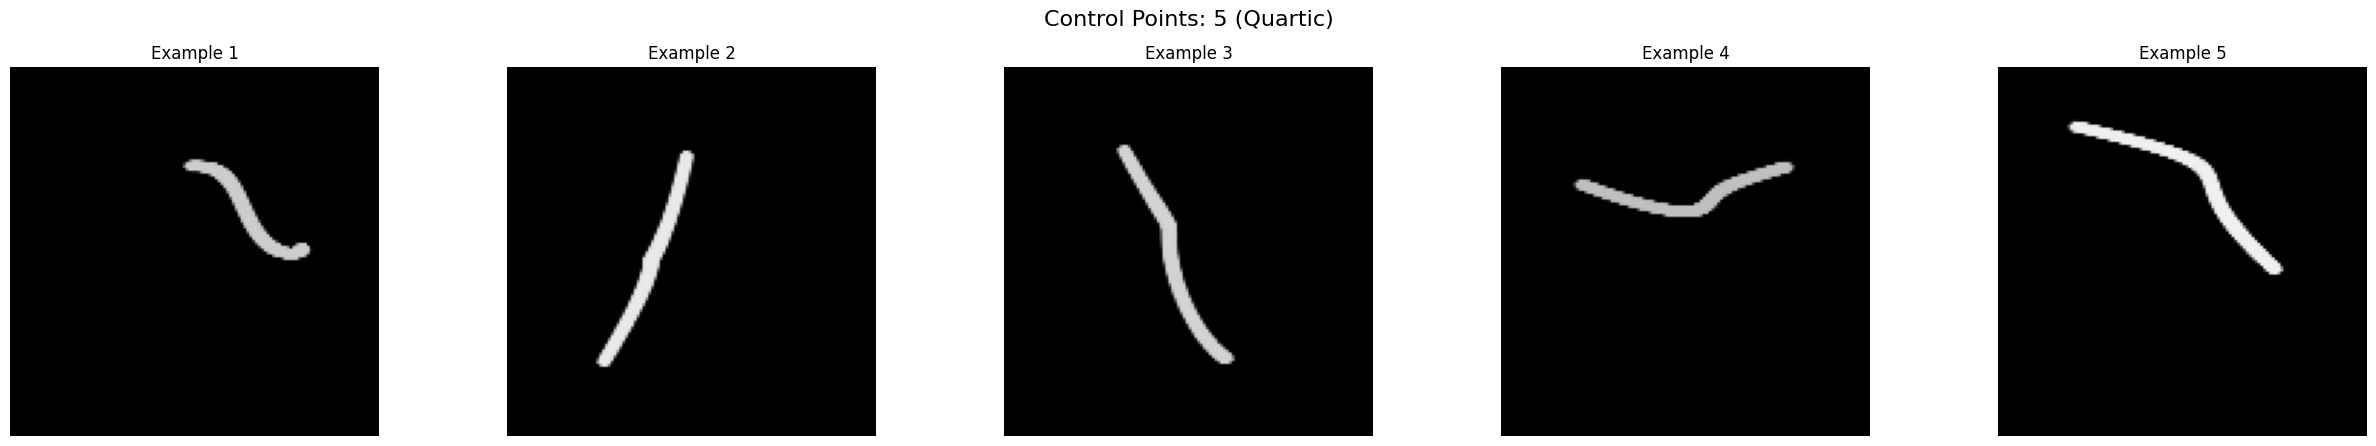

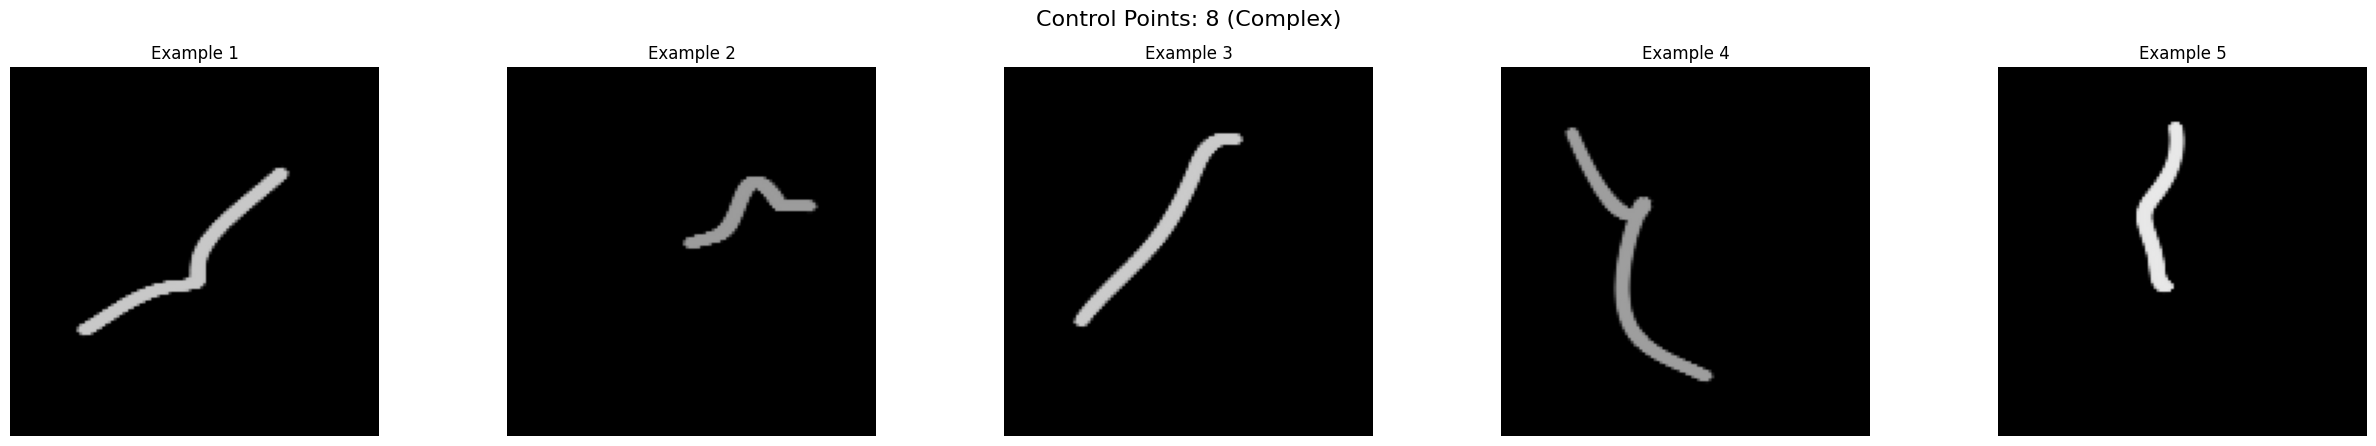

In [295]:
maker = CurveMaker()
show_samples(maker, {"num_control_points": 3}, num_examples=5, show_mask=False, title="Control Points: 4 (Simple Cubic)")
show_samples(maker, {"num_control_points": 5}, num_examples=5, show_mask=False, title="Control Points: 5 (Quartic)")
show_samples(maker, {"num_control_points": 8}, num_examples=5, show_mask=False, title="Control Points: 8 (Complex)")

### 5.2 `num_segments` (Length)
Chains multiple Bezier curves together. Great for making long, winding paths that traverse the whole image.

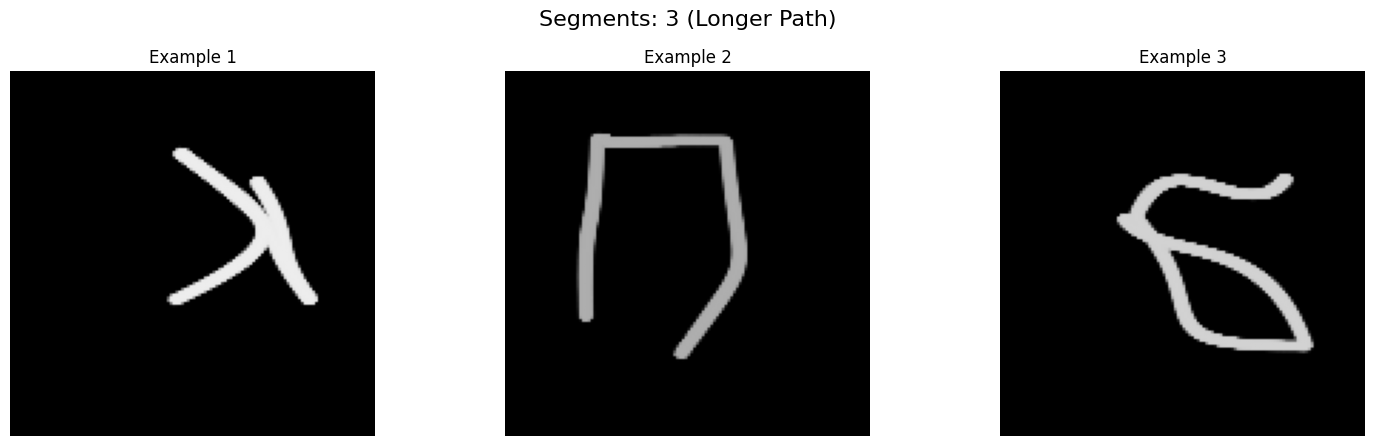

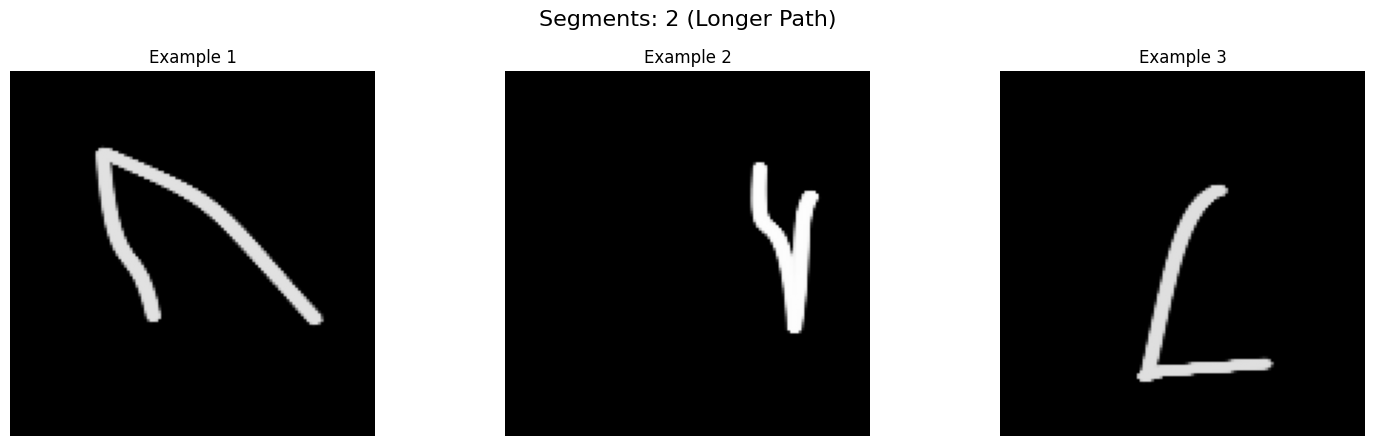

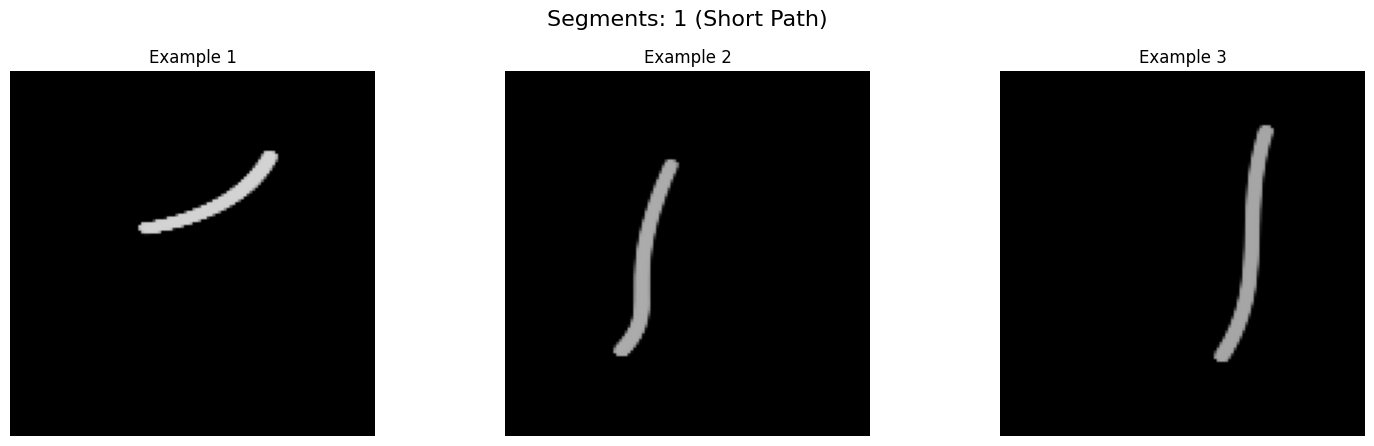

In [279]:
show_samples(maker, {"num_segments": 3, "num_control_points": 4}, num_examples=3, show_mask=False, title="Segments: 3 (Longer Path)")
show_samples(maker, {"num_segments": 2, "num_control_points": 4}, num_examples=3, show_mask=False, title="Segments: 2 (Longer Path)")
show_samples(maker, {"num_segments": 1, "num_control_points": 4}, num_examples=3, show_mask=False, title="Segments: 1 (Short Path)")

### 5.3 `width_range` (Thickness)
Visual thickness of the path in pixels. Can be a fixed number or a random range `(min, max)`.

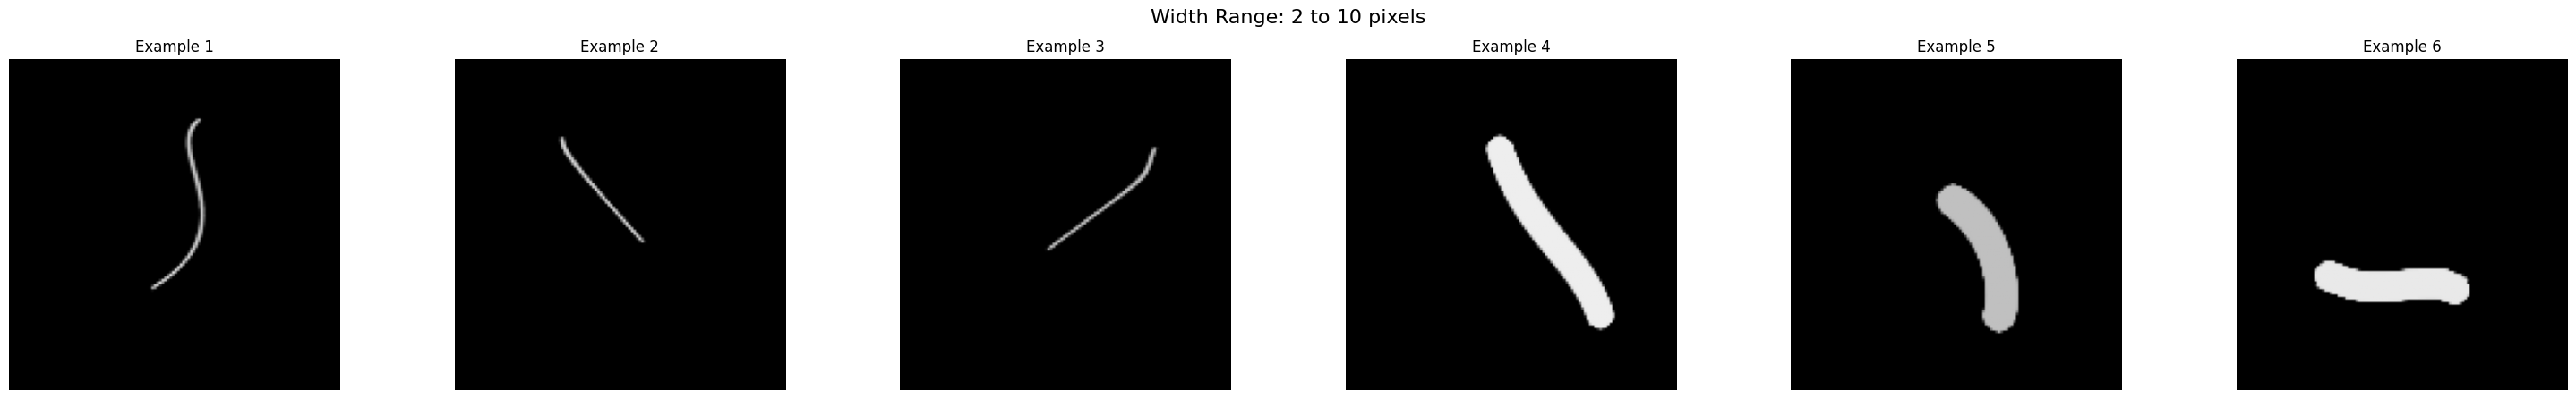

In [307]:
show_samples(maker, {"width_range": (0.001, 10)}, num_examples=6, show_mask=False, title="Width Range: 2 to 10 pixels")

### 5.4 `min_intensity` & `max_intensity` (Visibility)
How bright/faint the path is against the background. 1.0 is full white, 0.1 is nearly invisible.

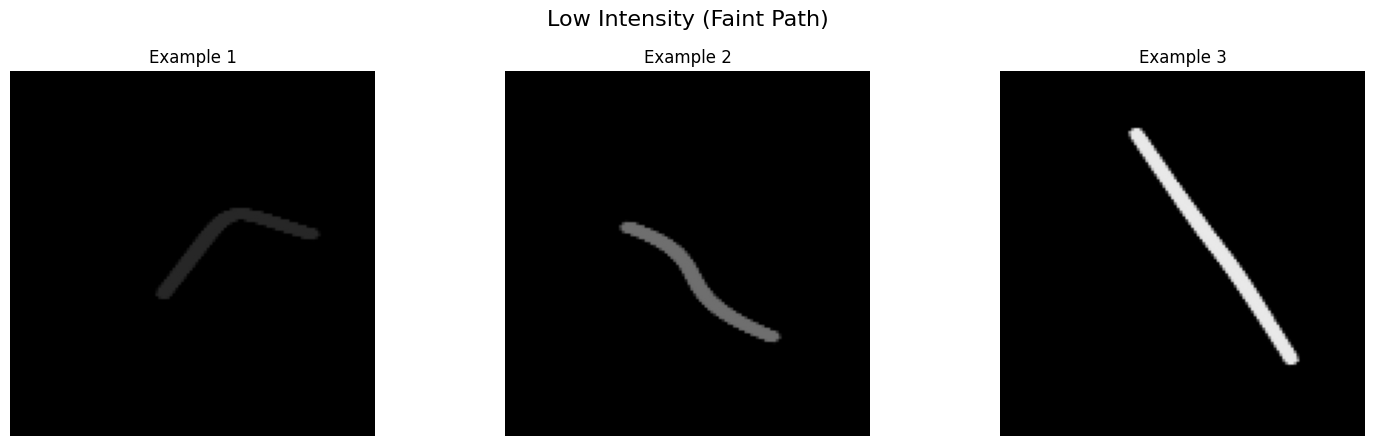

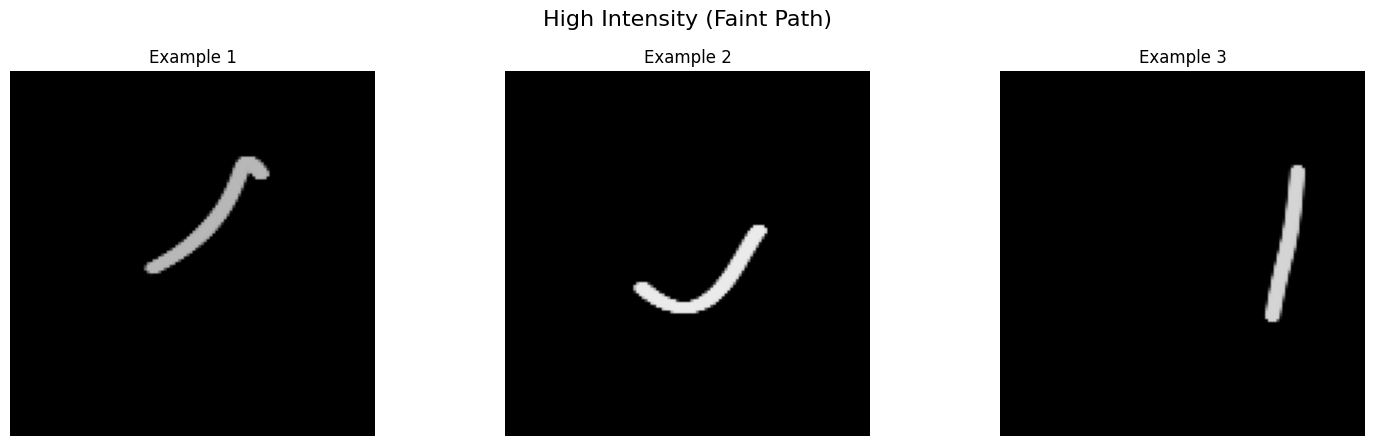

In [200]:
show_samples(maker, {"min_intensity": 0.01, "max_intensity": 1}, num_examples=3, show_mask=False, title="Low Intensity (Faint Path)")
show_samples(maker, {"min_intensity": 0.6, "max_intensity": 1}, num_examples=3, show_mask=False, title="High Intensity (Faint Path)")

### 5.5 `noise_prob` (DSA Artifacts)
Probability of adding sensor noise: white blobs and pixel static.

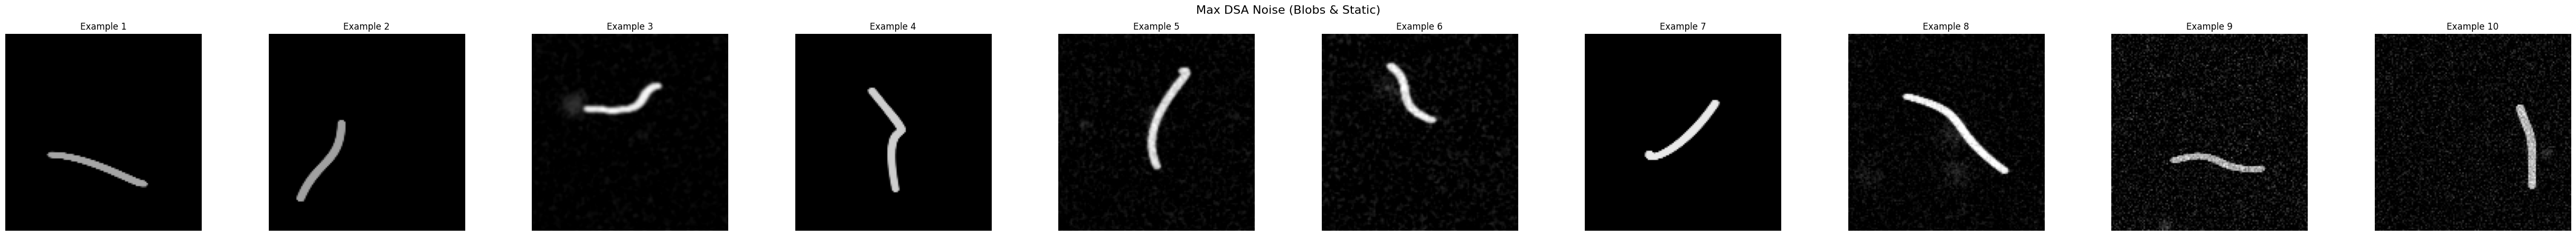

In [206]:
show_samples(maker, {"noise_prob": 0.5}, num_examples=10, show_mask=False, title="Max DSA Noise (Blobs & Static)")

### 5.6 `tissue_noise_prob` (Anatomical Background)
Probability of adding soft, low-frequency textures that simulate overlapping tissue or bone.

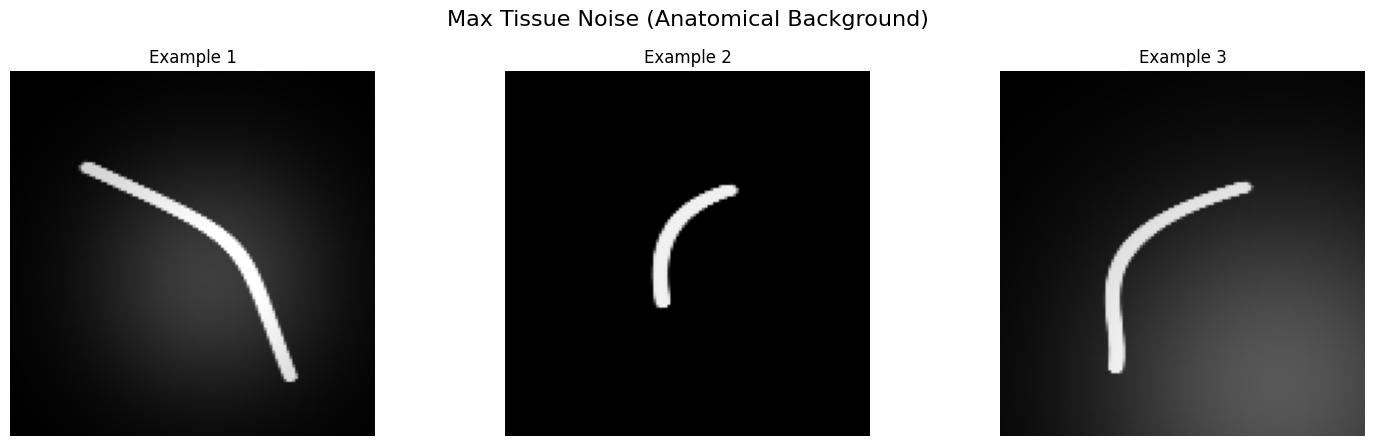

In [317]:
show_samples(maker, {"tissue_noise_prob": 0.5}, num_examples=3, show_mask=False, title="Max Tissue Noise (Anatomical Background)")

### 5.7 `invert_prob` (Negative Contrast)
Probability of inverting the image (making it a dark path on a light background).

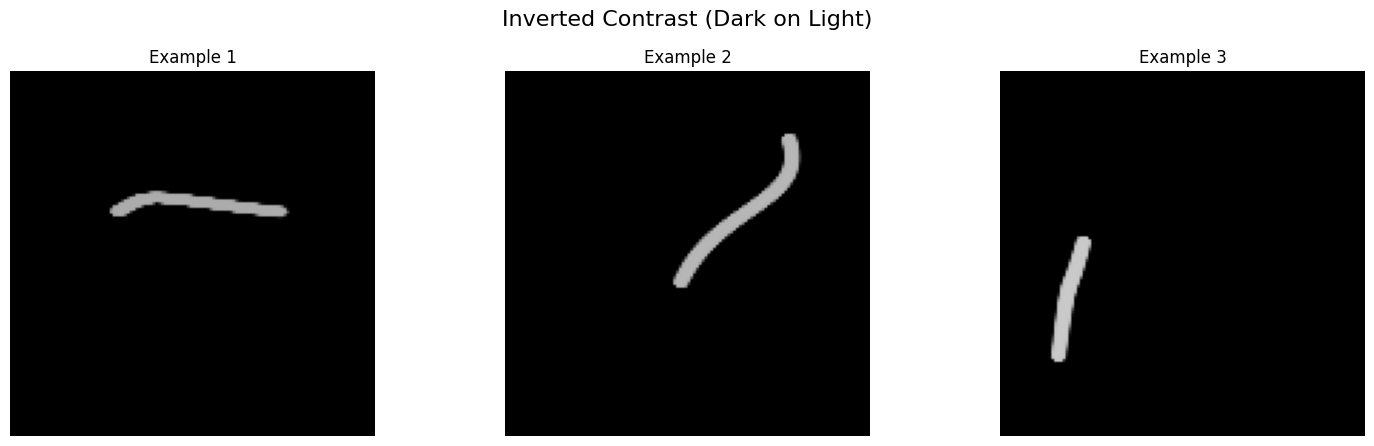

In [247]:
show_samples(maker, {"invert_prob": 0.5}, num_examples=3, show_mask=False, title="Inverted Contrast (Dark on Light)")

### 5.8 `curvature_factor` (Tightness)
Scales how far control points can move. Higher = sharper turns and loops.

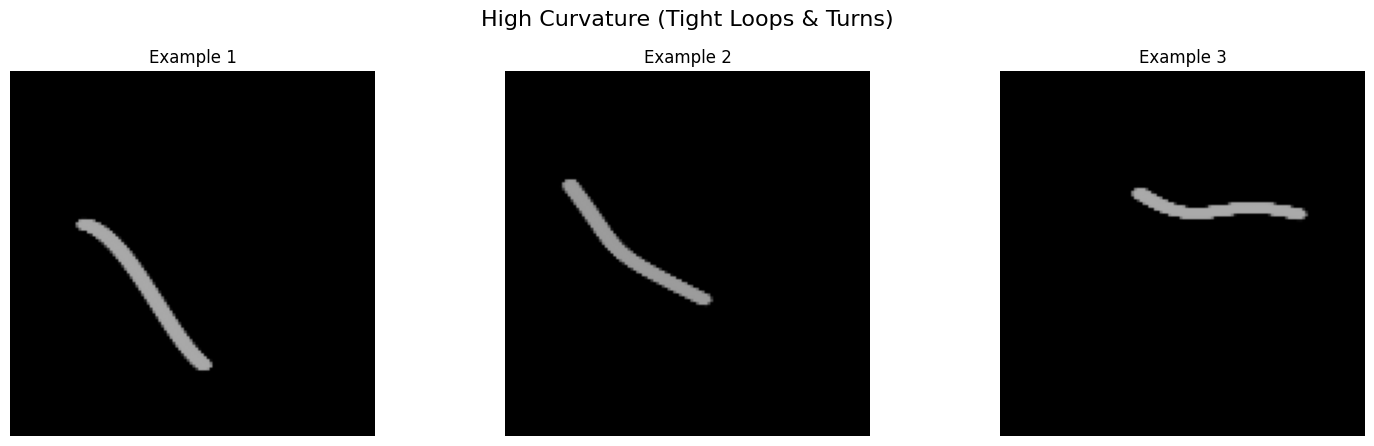

In [327]:
show_samples(maker, {"curvature_factor": 1}, num_examples=3, show_mask=False, title="High Curvature (Tight Loops & Turns)")

### 5.9 `topology` (Specific Shapes)
- `random`: Standard Bezier.
- `ribbon`: Forces an "Alpha" loop shape.

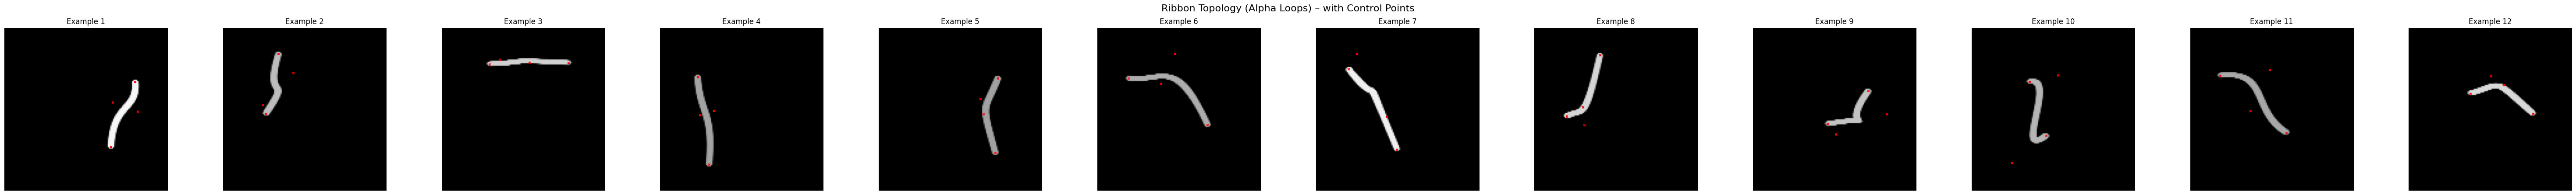

In [285]:
show_samples(maker, {"topology": "random"}, num_examples=12, show_mask=False, show_points=True, title="Ribbon Topology (Alpha Loops) – with Control Points")

### 5.10 `branches` (Bifurcations)
Adds random side-branches to the main curve.

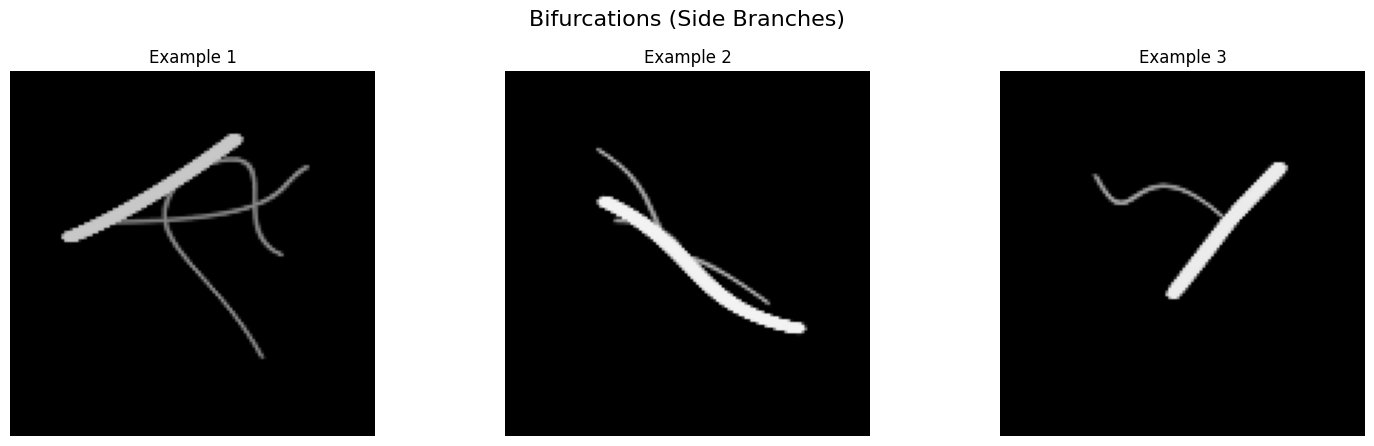

In [335]:
show_samples(maker, {"branches": True}, num_examples=3, show_mask=False, title="Bifurcations (Side Branches)")

### 5.11 `width_variation` (Tapering)
Changes path thickness along the curve (`wide_to_narrow` or `narrow_to_wide`).

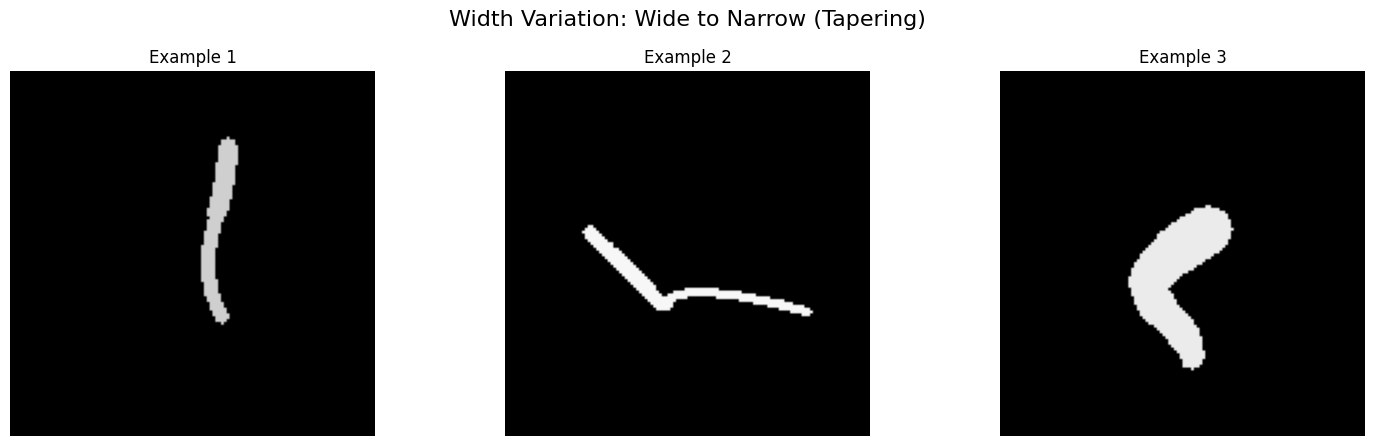

In [347]:
show_samples(maker, {"width_range": (2, 8), "width_variation": "wide_to_narrow"}, num_examples=3, show_mask=False, title="Width Variation: Wide to Narrow (Tapering)")

### 5.12 `intensity_variation` (Fading)
Changes path brightness along the curve (`bright_to_dim` or `dim_to_bright`).

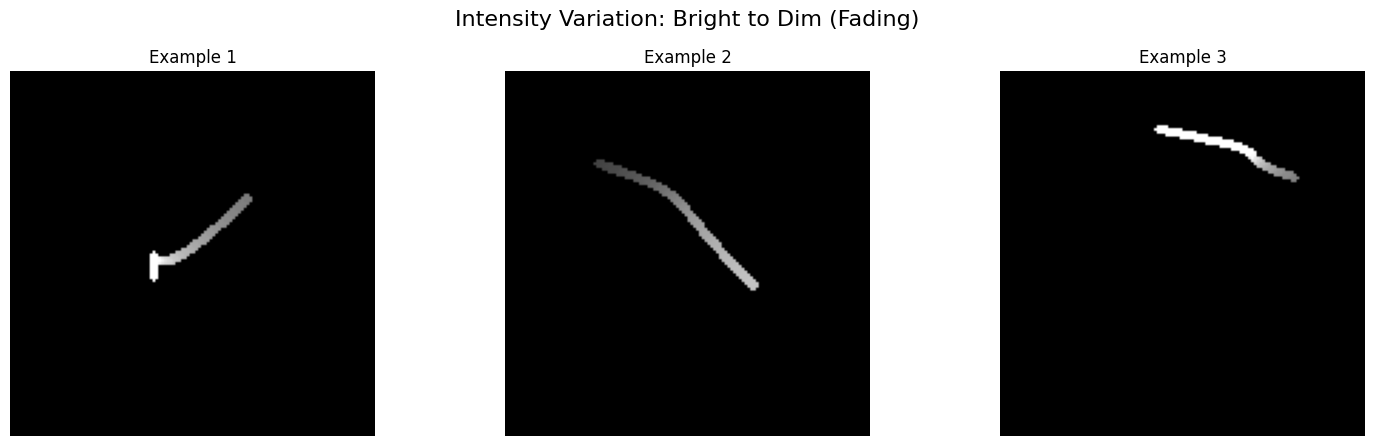

In [353]:
show_samples(maker, {"min_intensity": 0.2, "intensity_variation": "bright_to_dim"}, num_examples=3, show_mask=False, title="Intensity Variation: Bright to Dim (Fading)")

### 5.13 `background_intensity` (Baseline)
Sets a non-black background level. Useful for simulating non-subtracted DSA frames.

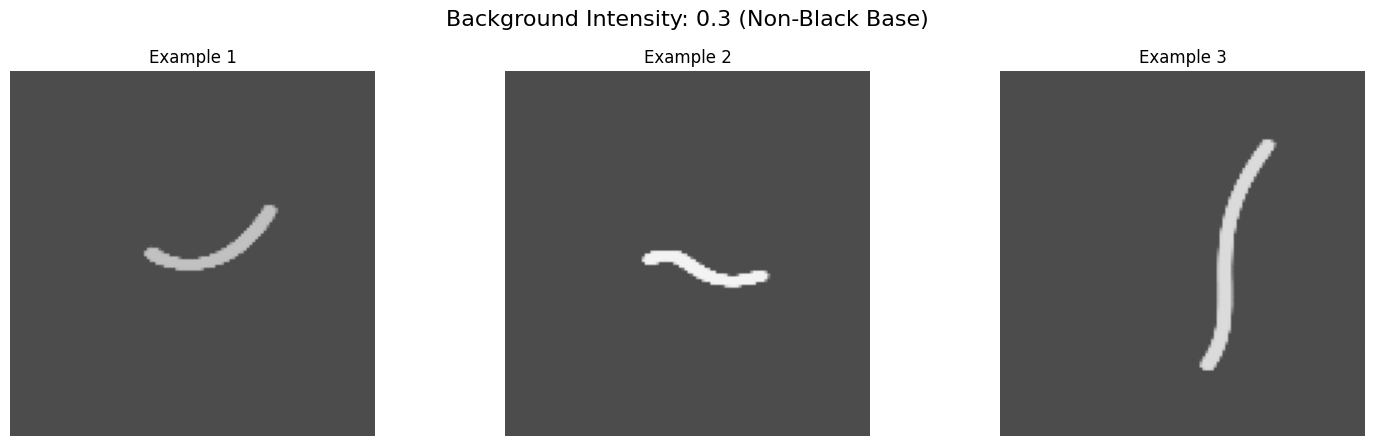

In [355]:
show_samples(maker, {"background_intensity": 0.3}, num_examples=3, show_mask=False, title="Background Intensity: 0.3 (Non-Black Base)")

### 5.14 `centerline_mask` (Precision)
- `True`: Ground truth is always 1-pixel thick (best for RL).
- `False`: Ground truth matches the visual thickness of the curve.

Showing comparison with masks enabled:


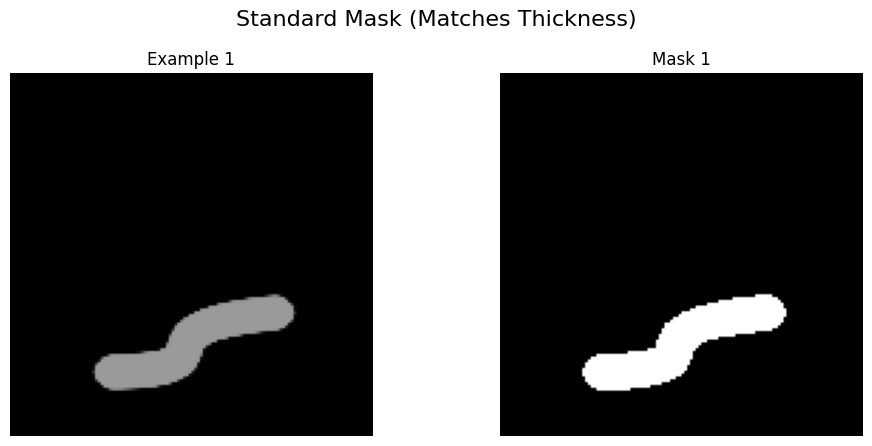

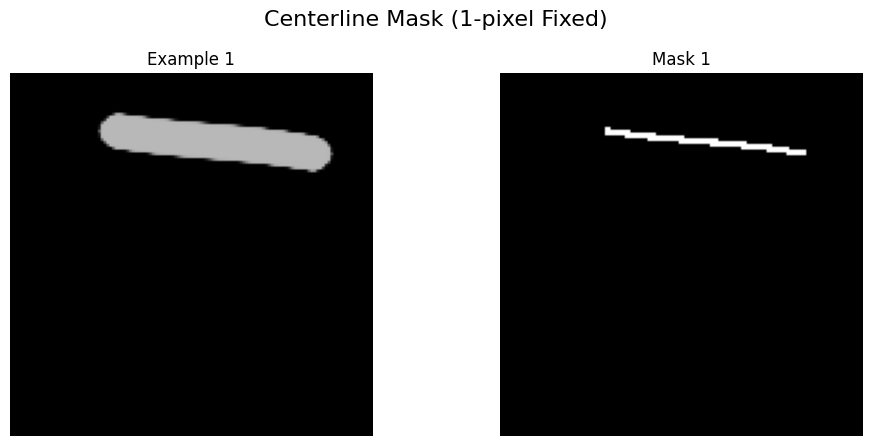

In [93]:
print("Showing comparison with masks enabled:")
show_samples(maker, {"width_range": (10, 10), "centerline_mask": False}, num_examples=1, show_mask=True, title="Standard Mask (Matches Thickness)")
show_samples(maker, {"width_range": (10, 10), "centerline_mask": True}, num_examples=1, show_mask=True, title="Centerline Mask (1-pixel Fixed)")

### 5.15 `allow_self_cross` & `self_cross_prob` (Loops)
Controls whether the curve is allowed to intersect itself. This adds a lot of difficulty for path-following agents.

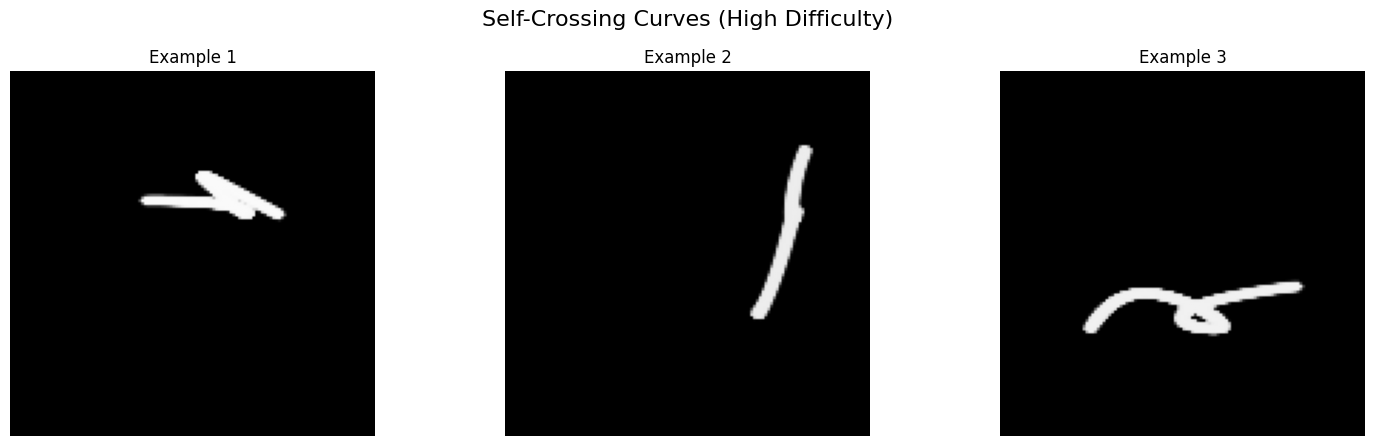

In [370]:
show_samples(maker, {
    "num_control_points": 8, 
    "curvature_factor": 2.0, 
    "allow_self_cross": True, 
    "self_cross_prob": 0.0
}, num_examples=3, show_mask=False, title="Self-Crossing Curves (High Difficulty)")

## 🎮 6. Interactive Playground

Now that you've seen each attribute in isolation, try mixing them together!

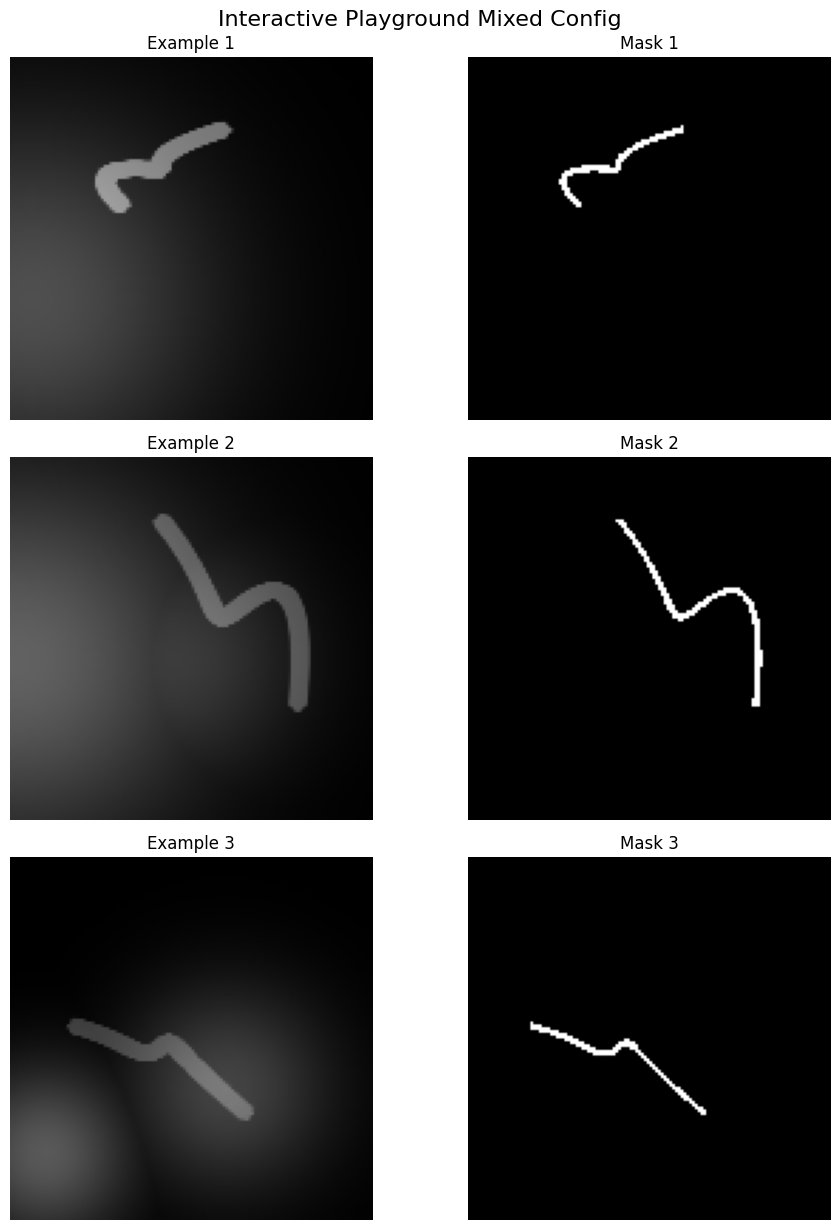

In [396]:
config = {
    "num_control_points": (4, 8),          # Range of control points
    "num_segments": 1,         # Range of segments
    "width_range": (0.001, 10),           # Path thickness
    "min_intensity": 0.2,   
    "max_intensity": 0.5,   # Path brightness (0.0 to 1.0)
    "noise_prob": 0.5,              # Probability of DSA noise
    "tissue_noise_prob": 0.8,             # Probability of background textures
    "centerline_mask": True,
    "topology": "hairpin",

}

show_samples(maker, config, num_examples=3, show_mask=True, title="Interactive Playground Mixed Config")